# **Week 3 assignment**
This project involves solving the Kaggle competition, which is a binary image classification problem where I will attempt to identify metastatic cancer in small image patches taken from larger digital pathology scans.
The procees involves training the model using train dataset using Convolutional Neural Network and tuning various hyperparameters to get optimum results. This model is then run through the test dataset to generate labels for them.

A set of Exploratory Data Analysis operations like inspecting the dataset, columns, rows, validating the class split was performed. The input for this project has set of images in test and train dataset and a CSV file that is a map of image id and label.
Given the volume of training data, it was not possible to execute the process by taking all the images in a memory. So, I decided to use Keras *ImageDataGenerator* that uses batching. The Training set of 220,000+ records were divided into training and validation dataset with normalized image form(requires converting a pixel value on a scale of 0-1). 
*ImageDataGenerator* class has an excellent function *flow_from_dataframe* that allows processing the images in batches and allows to set the target size for images. 
This input can directly be passed to the model for training. Post this, I created a model that comprised a Convolution Neural Network with 1st layer that accepts the input using a 3X3 filter with 8 feature maps. I kept lower value for feature map to avoid higher computational cost and avoid any overfitting. The activation function I used was *Relu*. 
Next, I used a *BatchNormalization* to reduce any overfitting that may occur. This was followed by *MaxPooling* layer of 2X2 for dimensionality reduction. The output of *MaxPooling* was passed to Flatten layer and another sequence of *Dense, BatchNomarlization* and 2 *Dense* layers before eventually resulting into desired binary output via *Dense* layer.

I chose Adam Optimizer with learning rate of 10^-4 and Binary CrossEntropy loss. The metrics used was accuracy. I finally fitted the model on the training dataset for 10 epochs with an *EarlyStopping* callback.

Finally, I ran the model on test dataset and extracted the result.

Import the packages

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers  import Adam
from sklearn.model_selection import train_test_split
from keras import regularizers, optimizers

In [42]:
# set working directories for train, train labels and test dataset.
WORKING_DIR = '/kaggle/input/histopathologic-cancer-detection'
train_dir = WORKING_DIR + "/train"
test_dir =  WORKING_DIR + "/test"
train_labels_path = WORKING_DIR + '/train_labels.csv'

load the training labels and get the dataset summary.

In [43]:
# read the label csv and query info()
trg_lbl_data = pd.read_csv(train_labels_path)
trg_lbl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [44]:
# inspect first few records.
trg_lbl_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


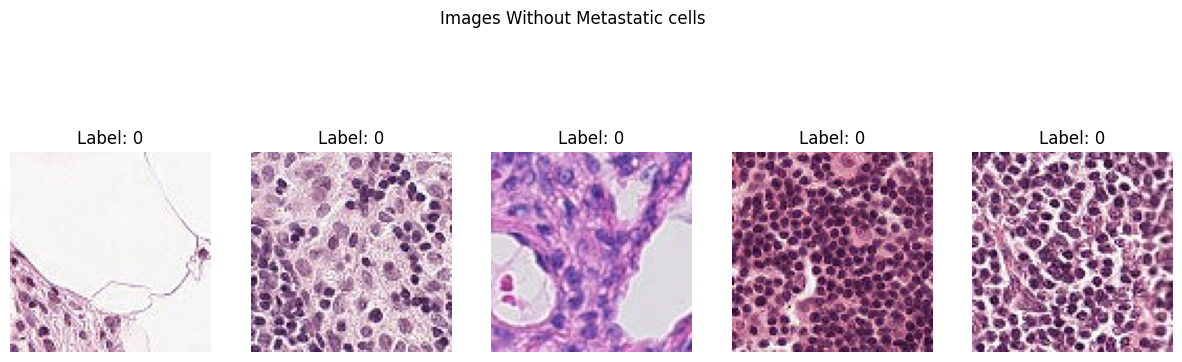

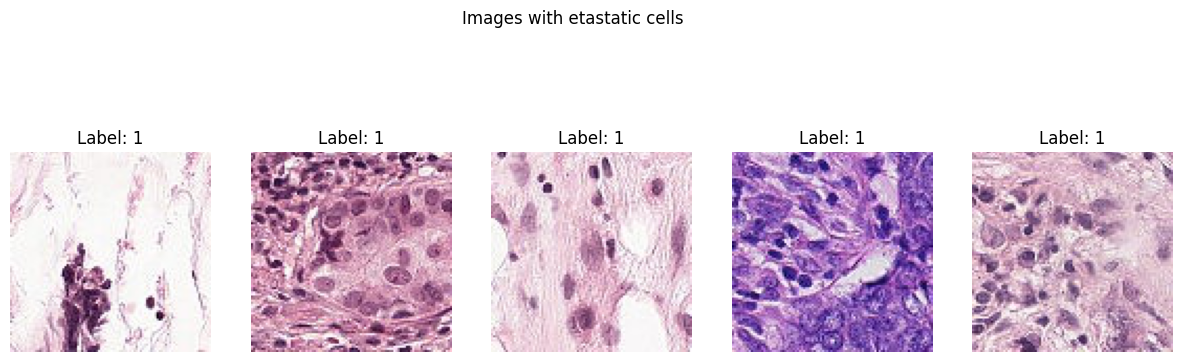

In [45]:
# Load first few images from both the categories.
def show_images(ids, labels, path, title):
    plt.figure(figsize=(15, 5))
    for i, (img_id, label) in enumerate(zip(ids, labels)):
        img_path = os.path.join(path, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, len(ids), i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(trg_lbl_data[trg_lbl_data['label'] == 0]['id'][:5], [0]*5, train_dir, "Images Without Metastatic cells")

show_images(trg_lbl_data[trg_lbl_data['label'] == 1]['id'][:5], [1]*5, train_dir, "Images with metastatic cells")

In [46]:
train_images_count = len(os.listdir(train_dir))
test_images_count = len(os.listdir(test_dir))

print(train_images_count,test_images_count)

total_len_of_dataset = train_images_count + test_images_count
print(f"Training images count: " + str(round(train_images_count / total_len_of_dataset, 2)))
print(f"Test images count: " + str(round(test_images_count / total_len_of_dataset, 2)))

220025 57458
Training images count: 0.79
Test images count: 0.21


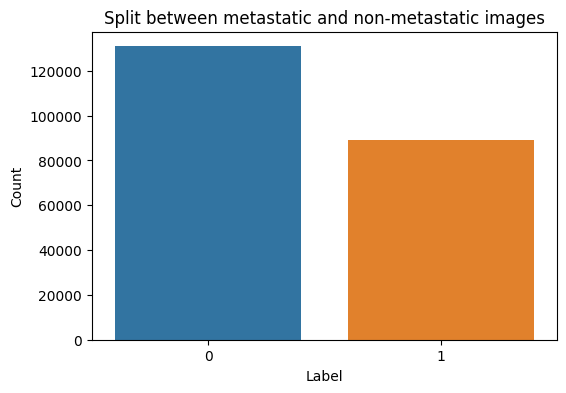

In [47]:
# Display a histogram for the two categories.
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=trg_lbl_data)
plt.title('Split between metastatic and non-metastatic images')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [48]:
# Print the size and the color channels for images.
sample_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
sample_image = Image.open(sample_image_path)
print(f"Sample image dimensions: {sample_image.size}")
print(f"Number of channels in the sample image: {sample_image.mode}\n\n")

Sample image dimensions: (96, 96)
Number of channels in the sample image: RGB




In [49]:
# add .tif extenstion to file Ids
def append_ext(name):
    if name.endswith('.tif'):
        return name      
    return name+".tif"

trg_lbl_data["id"]=trg_lbl_data["id"].apply(append_ext)

trg_lbl_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [50]:
# create ImageDataGenerator instance with a normalized scale and 75:25::train:validation split.
train_data_gen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [51]:
# create training flow object for model input
train_generator=train_data_gen.flow_from_dataframe(
        dataframe=trg_lbl_data,
        directory='/kaggle/input/histopathologic-cancer-detection/train/',
        x_col="id",
        y_col="label",
        subset="training",
        batch_size=64,
        seed=421,
        shuffle=True,
        class_mode="raw",
        target_size=(32,32))

# validate train generator
print(train_generator.image_shape)


Found 165019 validated image filenames.
(32, 32, 3)


In [52]:
# create validatio flow object for model input
valid_generator=train_data_gen.flow_from_dataframe(
        dataframe=trg_lbl_data,
        directory='/kaggle/input/histopathologic-cancer-detection/train/',
        x_col="id",
        y_col="label",
        subset="validation",
        batch_size=64,
        seed=842,
        shuffle=True,
        class_mode="raw",
        target_size=(32,32))

# validate validation generator
print(valid_generator.image_shape)
print(len(valid_generator.filepaths))

Found 55006 validated image filenames.
(32, 32, 3)
55006


Create a Convolution Neural Network for Image processing. The model has multiple layers which perform specific tasks like reducing dimensionality, avoiding overfitting, ANN layer etc. 
The optimization hyperparameters used
- Adam Optimizer with learning rate 1e-4
- Binary Cross Entropy for loss
Accuracy for metrics evaluation

In [53]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=[32, 32, 3]))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(8, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(250, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(120, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation="sigmoid", name="output_layer"))
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
my_callbacks = EarlyStopping(monitor='accuracy', patience=10, mode='max')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │        72,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 250)            │         1,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 120)            │        30,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         6,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,311 (430.90 KB)

 Trainable params: 109,795 (428.89 KB)

 Non-trainable params: 516 (2.02 KB)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 318s 122ms/step - accuracy: 0.7652 - loss: 0.4919 - val_accuracy: 0.8020 - val_loss: 0.4349
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 302s 117ms/step - accuracy: 0.8020 - loss: 0.4363 - val_accuracy: 0.8049 - val_loss: 0.4296
Epoch 3/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 311s 120ms/step - accuracy: 0.8141 - loss: 0.4115 - val_accuracy: 0.8174 - val_loss: 0.4050
Epoch 4/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 313s 121ms/step - accuracy: 0.8232 - loss: 0.3968 - val_accuracy: 0.8240 - val_loss: 0.3940
Epoch 5/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 322s 121ms/step - accuracy: 0.8274 - loss: 0.3860 - val_accuracy: 0.8199 - val_loss: 0.4001
Epoch 6/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 313s 121ms/step - accuracy: 0.8322 - loss: 0.3756 - val_accuracy: 0.8207 - val_loss: 0.3971
Epoch 7/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 315s 122ms/step - accuracy: 0.8352 - loss: 0.3699 - val_accuracy: 0.8304 - val_loss: 0.3843
Epoch 8/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 311s 120ms/step - accuracy: 0.8

In [ ]:
# retrieve model summary
model.summary()
# train the model with a batch size of 256 for 10 epoch and an EarlyStopping callback.
history = model.fit(train_generator, batch_size=256, epochs=10, verbose=1, validation_data=valid_generator, callbacks=[my_callbacks])

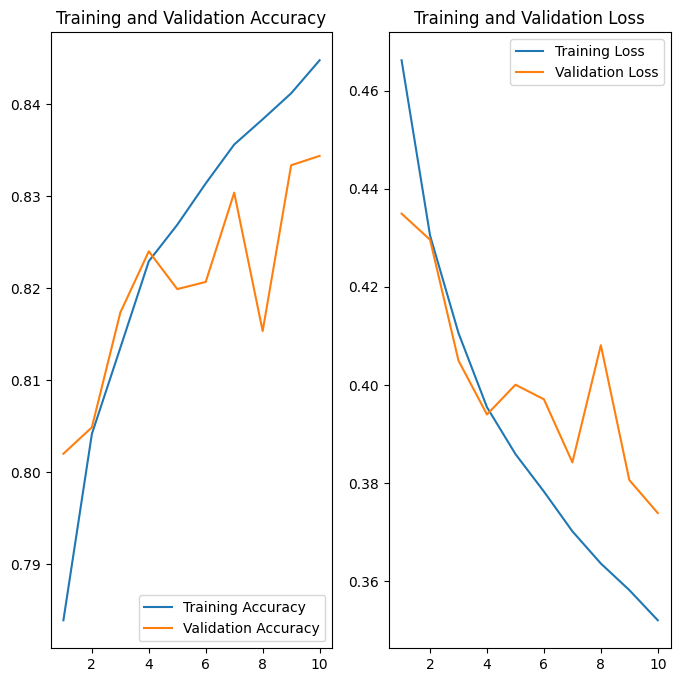

In [55]:
# draw accuracy and training/validation loss charts
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
# create ImageDataGenerator for test set
test_data_gen=ImageDataGenerator(rescale=1./255.)
test_generator = test_data_gen.flow_from_directory(
    directory='/kaggle/input/histopathologic-cancer-detection/',
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=56,
    class_mode= 'binary',
    classes=['test'],
    shuffle=False,
    seed=43
)

len(test_generator.filenames)

test_generator.filepaths[0]

Found 57458 images belonging to 1 classes.


'/kaggle/input/histopathologic-cancer-detection/test/00006537328c33e284c973d7b39d340809f7271b.tif'

In [57]:
# generate prediction on test dataset 
result = (model.predict(test_generator) > 0.5).astype("int32")

1027/1027 ━━━━━━━━━━━━━━━━━━━━ 79s 77ms/step


In [58]:
result

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]], dtype=int32)

In [60]:
# result.shape
out = result.reshape(len(result),)
out

array([1, 1, 0, ..., 0, 1, 0], dtype=int32)

In [61]:
# modify filenames to remove 'test' directory name
files = [s.strip('test/') for s in test_generator.filenames]
files[:10]

['00006537328c33e284c973d7b39d340809f7271b.tif',
 '0000ec92553fda4ce39889f9226ace43cae3364e.tif',
 '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif',
 '000253dfaa0be9d0d100283b22284ab2f6b643f6.tif',
 '000270442cc15af719583a8172c87cd2bd9c7746.tif',
 '000309e669fa3b18fb0ed6a253a2850cce751a95.tif',
 '000360e0d8358db520b5c7564ac70c5706a0beb0.tif',
 '00040095a4a671280aeb66cb0c9231e6216633b5.tif',
 '000698b7df308d75ec9559ef473a588c513a68aa.tif',
 '0006e1af5670323331d09880924381d67d79eda0.tif']

In [62]:
# create a dataframe with test image id and label
df_result = pd.DataFrame({'id':files, 'label':out})

In [63]:
df_result.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b.tif,1
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,0
4,000270442cc15af719583a8172c87cd2bd9c7746.tif,0


In [64]:
# save the output.
df_result.to_csv('/kaggle/working/submission.csv', index=False)

It was observed that the maximum accuracy obtained using 75:25::train:validation split was about 83%. 

The training data resulted in a loss of 0.3496 and accuracy of 84%. The validation data (25% of the dataset) has a loss of 0.3739 and accuracy of 83%. The model gives about same performance for training and test data. This was achieved on tweaking various parameters and reducing learning rate. However, reducing the learning rate further was slowing down the training drastically and even timing out the program execution. So, I believe this is a good output considering the speed and input. 